# PHYS3116

## Stellar Model

## From Part 1:

In [1]:
# Import the libraries we need.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline

In [2]:
# Define physical constants.
# All values come from Appendix A of Carroll & Ostlie

a = 7.565767E-16               # Radiation constant, J mol^-3 K^-4
G = 6.67428E-11                # Gravitational constant, m^3 kg^-1 s^-2
c = 2.99792458E8               # Speed of light, m s^-1
boltzmann = 1.3806504E-23      # Boltzmann's constant, J K^-1
H_mass = 1.673532499E-27       # Mass of a hydrogen atom, kg
sigma = 5.670400E-8            # Stefan-Boltzmann constant, W m^-2 K^-4
R = boltzmann/H_mass           # Ideal gas constant, J K^-1 kg^-1

# Solar parameters:

Msun = 1.989E30                # Mass of Sun
Rsun = 6.95508E8               # Radius of Sun
Lsun = 3.839E26                # Luminosity of Sun

# Stellar parameters:

Mtot = 1.2*Msun                # 20% more massive than the Sun 
mfraction = 1e-8               # Fractional mass of core 
X = 0.7                        # Mass fraction of hydrogen
Y = 0.2                        # Mass fraction of helium
log_pc_i = 17.1                # Initial estimate for pressure at the centre of the star (slightly higher than Sun)
log_tc_i = 7.4                 # Initial estimate for temperature at the centre of the star (slightly higher than Sun)
log_rs_i = 8.85                # Initial estimate for full radius of the star (slightly higher than Sun)
log_ls_i = 26.6                # Initial estimate for full luminosity of the star (slightly higher than Sun)

In [3]:
# Define functions from Part 1:

def mean_molecular_weight(X,Y):
    """
    Calculates the mean molecular weight.
    
    Parameters
    ----------
    X: float
        Mass fraction of hydrogen
    Y: float
        Mass fraction of helium
        
    Returns
    -------
    mu: float
        Mean molecular weight
    """
    
    Z = (1 - X - Y)
    mu = 1/((2*X)+(0.75*Y)+(0.5*Z))
    
    return mu

def density(P,T,mu):
    """
    Calculates the density.
    
    Parameters
    ----------
    P: float
        Total pressure
    T: float
        Temperature
    mu: float
        Mean molecular weight
        
    Returns
    -------
    rho: float
        Density
    """
    
    rho = (mu/(R*T))*(P-(a*T**4)/3)
    
    return rho

def pressure_to_density_beta(X, Y, logT, logP):
    """
    Accepts values for X, Y, log(T), and log(P), and returns values for rho and beta.
    """
    
    mu = mean_molecular_weight(X,Y)
    rho = density(10**logP, 10**logT, mu)
    gas_pressure = (R/mu)*rho*(10**logT)
    beta = gas_pressure/(10**logP)
    
    return rho, beta

def opacity(logT, logrho, X, Y):
    T = 10**logT
    rho = 10**(logrho - 3)        # -3 converts input quantities from SI to cgs units to support coefficients below
    
    #Kramer's opacity law: kappa is proportional to rho and T^-3.5
    k_bf = (4.34e25*(1-X-Y)*(1+X)*rho*np.power(T,-3.5))/(2.82*np.power(rho*(1+X),0.2))  #bound-free absorption
    k_ff = 3.68e22*(X+Y)*(1+X)*rho*np.power(T,-3.5)                                     #free-free absorption
    k_es = 0.2*(1+X)                                                                    #electron scattering
    
    return np.log10(k_bf + k_ff + k_es) - 1                                             # -1 to convert to SI units

def energy_generation(logrho,logT,X,Y):
    t6 = (10**logT)/(1E6)
    rho = 10**logrho
    Xcno = 0.7263*(1-X-Y)
    
    eps_pp = 0.241*rho*np.power(X,2)*np.power(t6,-2/3)*np.exp(-33.8/np.power(t6,1/3))
    eps_CNO = 8.67E20*rho*X*Xcno*np.power(t6,-2/3)*np.exp(-152.28/np.power(t6,1/3))

    eps = eps_pp + eps_CNO
    
    return eps

## From Part 2:

In [4]:
# Define functions from Part 2:

def centre(m, log_pc_i, log_tc_i, X, Y):
    m = mfraction*Mtot
    p_c_i = 10**log_pc_i
    t_c_i = 10**log_tc_i
    
    ## Incorporate previously defined functions ##
    rho_c, beta_c = pressure_to_density_beta(X=X, Y=Y, logT=log_tc_i, logP=log_pc_i)
    epsilon_c = energy_generation(logrho=np.log10(rho_c), logT=log_tc_i, X=X, Y=Y)
    log_kappa_c = opacity(logT=log_tc_i, logrho=np.log10(rho_c), X=X, Y=Y)
    kappa_c = 10**log_kappa_c
    
    ## Calculate radius, luminosity, and pressure ##
    r_c = np.power(0.75/(np.pi*rho_c), 1/3)*np.power(m, 1/3)
    l_c = epsilon_c*m
    p_c = p_c_i - (3*G/(8*np.pi))*np.power((4*np.pi*rho_c)/3, 4/3)*np.power(m, 2/3)
    
    ## Define temperature gradients ##
    grad_ad = (((1-beta_c)*(4+beta_c))/(beta_c**2) + 1)/(((4*(1-beta_c)*(4+beta_c))/(beta_c**2))+2.5)
    grad_rad = (3*kappa_c*l_c*p_c)/(16*np.pi*G*a*c*m*np.power(t_c_i, 4))
    
    ## Calculate temperature for convective/radiative core ##
    if grad_rad < grad_ad:
        t_4 = np.power(t_c_i, 4) - (0.5/(a*c))*np.power(0.75/np.pi, 2/3)*kappa_c*epsilon_c*np.power(rho_c, 4/3)*np.power(m, 2/3)
        t_c = np.power(t_4, 1/4)
        #print('Core is radiative!')
    else:
        ln_t = np.log(t_c_i) - np.power(np.pi/6, 1/3)*G*grad_ad*np.power(rho_c, 4/3)*np.power(m, 2/3)/p_c_i
        t_c = np.exp(ln_t)
        #print('Core is convective!')
    
    return r_c, l_c, p_c, t_c

def surface(Mtot, log_rs_i, log_ls_i, init_ps):
    r_s = 10**log_rs_i
    l_s = 10**log_ls_i
    t_s = np.power(l_s/(4*np.pi*np.power(r_s, 2)*sigma), 1/4)
    
    trial_ps = init_ps
    candidate_ps = 0
    
    while np.abs((trial_ps - candidate_ps)/trial_ps) > 0.05:
        diff = trial_ps - candidate_ps
        trial_ps = trial_ps - 0.1*diff
        rho_s, beta_s = pressure_to_density_beta(X=X, Y=Y, logT=np.log10(t_s), logP=np.log10(trial_ps))
        log_kappa_s = opacity(logT=np.log10(t_s), logrho=np.log10(rho_s), X=X, Y=Y)
        kappa_s = 10**log_kappa_s
        candidate_ps = (2*G*Mtot)/(3*kappa_s*(r_s**2))
        
    return r_s, l_s, candidate_ps, t_s

def partial_derivatives(rlpt, m):
    # Unpack rlpt
    r = rlpt[0]
    l = rlpt[1]
    p = rlpt[2]
    t = rlpt[3]
    
    # Convert to log10 as this is used in our previous functions
    logl = np.log10(l)
    logp = np.log10(p)
    logt = np.log10(t)
    
    # Use previous functions to calculate rho, beta, epsilon, and kappa
    rho, beta = pressure_to_density_beta(X=X, Y=Y, logT=logt, logP=logp)
    logrho = np.log10(rho)
    epsilon = energy_generation(logrho=logrho, logT=logt, X=X, Y=Y)
    log_kappa = opacity(logT=logt, logrho=logrho, X=X, Y=Y)
    kappa = 10**log_kappa
    
    # Calculate grad as the lesser of grad_rad and grad_ad
    grad_ad = (((1-beta)*(4+beta))/(beta**2) + 1)/(((4*(1-beta)*(4+beta))/(beta**2))+2.5)
    grad_rad = (3*kappa*l*p)/(16*np.pi*G*a*c*m*np.power(t, 4))
    grad = min(grad_rad, grad_ad)
    
    # Find the derivatives in our equations of stellar structure
    drdm = 1/(4*np.pi*np.power(r, 2)*rho)
    dldm = epsilon
    dpdm = -(G*m)/(4*np.pi*np.power(r, 4))
    dtdm = -(G*m*t*grad)/(4*np.pi*p*np.power(r, 4))

    return [drdm, dldm, dpdm, dtdm]

## Part 3:

In Part 3 we will integrate the stellar structure equations outward from the centre and inward from the surface. The goal is for the two integrations to meet at $m = \frac{2}{3}M_{tot}$, though this probably won't be the case using our initial estimates. Here we will calculate the offsets between the integrations at the meeting point. These can then be used in Part 4 to improve our model. 

To do these integrations, we will use `scipy.integrate.odeint`. It can integrate all four stellar structure equations at once (what we will do here), or you can choose to integrate them separately. As input, we will need our initial conditions ($R_s$, $L_s$, $P_c$, and $T_c$), our function from Part 2 that returns the gradients we want to integrate ($\frac{\partial R}{\partial m}$, $\frac{\partial L}{\partial m}$, $\frac{\partial P}{\partial m}$, and $\frac{\partial T}{\partial m}$), and a set of mass points at which we want values for $R$, $L$, $P$, and $T$ to be calculated (in this case from $m$ to $\frac{2}{3}M_{tot}$, or from $M_{tot}$ to $\frac{2}{3}M_{tot}$). We will have the integrations run one extra step past the meeting point (for reasons that will become clear in Part 4).

For the outward integration we will set the mass step size to be $(\frac{2}{3}M_{tot} - m)/10^4$. For the inward integration we need to add a bit more complexity. The gradients in $T$ and $R$ are very steep at the outside edge of the star (i.e. at the surface), so we need to use very small integration steps at first. We can then make these steps larger (to cut down on computation) once we get a small distance into the star. Here we will divide the outermost $0.01\%$ of the mass into $10^4$ steps, and the remaining inward integration into $10^4$ steps. Note that this may require some adjustment for different models.

Let's write a program that takes the initial estimates as inputs, calculates initial centre and surface values and derivatives for $R$, $L$, $P$, and $T$ using our earlier functions, chooses step sizes, and runs our two integrations. The program will also have the option to plot figures showing the values of $R$, $L$, $P$, and $T$ at all mass points, and will return an array of the offsets between the integrations at the meeting point.

In [5]:
def model(rlpt, do_plot):
    
    log_rs, log_ls, log_pc, log_tc = np.log10(rlpt)
    
    meeting_point = 0.67
    
    # Choose mass steps for the integration from the inner point,
    # integrating outwards to a mass of (Mtot*meeting_point)
    
    mgrid_c = Mtot*np.linspace(mfraction, meeting_point, 10000)
    mgrid_c = np.append(mgrid_c, mgrid_c[-1] + np.diff(mgrid_c)[0])
    mass_step_out = mgrid_c
    
    # Set up the initial values at the centre
    
    rlpt_c = centre(m=mfraction,log_pc_i=log_pc,log_tc_i=log_tc,X=X,Y=Y)
    
    # Integrate from the centre outward
    
    solve_outwards = odeint(partial_derivatives, rlpt_c, mgrid_c)
    
    # Choose mass steps for the integration from the surface,
    # integrating inwards to a mass of (Mtot*meeting_point).
    # We take tiny steps when we are close to the surface,
    # since change is rapid there.
    
    mgrid_s1 = np.linspace(Mtot, Mtot*(2.9999/3), 10000)
    mgrid_s2 = np.linspace(Mtot*(2.9999/3), meeting_point*Mtot, 10000)
    mgrid_s2 = np.append(mgrid_s2, mgrid_s2[-1] + np.diff(mgrid_s2)[0])
    mgrid_s = np.concatenate([mgrid_s1[:-1], mgrid_s2], axis=0)
    mass_step_in = mgrid_s
    
    # Set up the initial values at the surface
    
    rlpt_s = surface(Mtot=Mtot, log_rs_i=log_rs, log_ls_i=log_ls, init_ps=1e3)
    
    # Integrate from the surface inwards
    
    solve_inwards = odeint(partial_derivatives, rlpt_s, mgrid_s)
    
    # Calculate the offsets at the meeting point
    
    delta_r = solve_outwards[-2][0] - solve_inwards[-2][0]    # [-2] is meeting point, [0] is radius
    delta_l = solve_outwards[-2][1] - solve_inwards[-2][1]    # '' [1] is luminosity
    delta_p = solve_outwards[-2][2] - solve_inwards[-2][2]    # '' [2] is pressure
    delta_t = solve_outwards[-2][3] - solve_inwards[-2][3]    # '' [3] is temperature
    
    # If requested, make some plots
    
    if do_plot:
        
        # Plots showing step distribution for each integration
        
        fig = plt.figure(figsize=(15,7.5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.scatter(np.arange(len(mgrid_c)), mgrid_c)
        ax1.axvline(x=10000, ls='--', c='k')

        ax2.scatter(np.arange(len(mgrid_s)), mgrid_s)
        ax2.axvline(x=0, ls='--')
        ax2.axvline(x=10000, ls='--')
        ax2.axvline(x=20000, ls='--', c='k')
        ax2.text(x= 1500, y = 1.9e30, s='Outermost Surface')
        
        ax1.set_xlabel('Outward Steps')
        ax1.set_ylabel('Mass of Star')
        ax2.set_xlabel('Inward Steps')
        ax2.set_ylabel('Mass of Star')
        plt.show()
        
        # Plots showing R, L, P, T against M
        
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        
        ax1.plot(mass_step_out/Msun, solve_outwards[:,0]/Rsun)
        ax1.plot(mass_step_in/Msun, solve_inwards[:,0]/Rsun)
        ax1.set_xlabel('Mass [solar masses]')
        ax1.set_ylabel('Radius [solar radii]')
        
        ax2.plot(mass_step_out/Msun, solve_outwards[:,1]/Lsun)
        ax2.plot(mass_step_in/Msun, solve_inwards[:,1]/Lsun)
        ax2.set_xlabel('Mass [solar masses]')
        ax2.set_ylabel('Luminosity [solar luminosities]')
        
        ax3.plot(mass_step_out/Msun, solve_outwards[:,2])
        ax3.plot(mass_step_in/Msun, solve_inwards[:,2])
        ax3.set_xlabel('Mass [solar masses]')
        ax3.set_ylabel('Pressure')
        
        ax4.plot(mass_step_out/Msun, solve_outwards[:,3])
        ax4.plot(mass_step_in/Msun, solve_inwards[:,3])
        ax4.set_xlabel('Mass [solar masses]')
        ax4.set_ylabel('Temperature')
        
        plt.show()
        
    return (np.array([delta_r, delta_l, delta_p, delta_t]))  

We can now test this for our star. Note that this version of the `model` function doesn't actually need the `rlpt` argument, but it is included here because this will be essential in Part 4 when we want to improve our model.

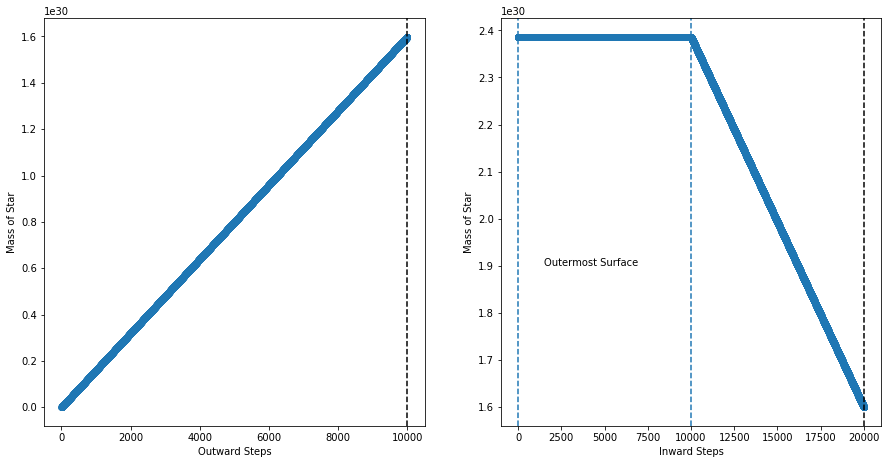

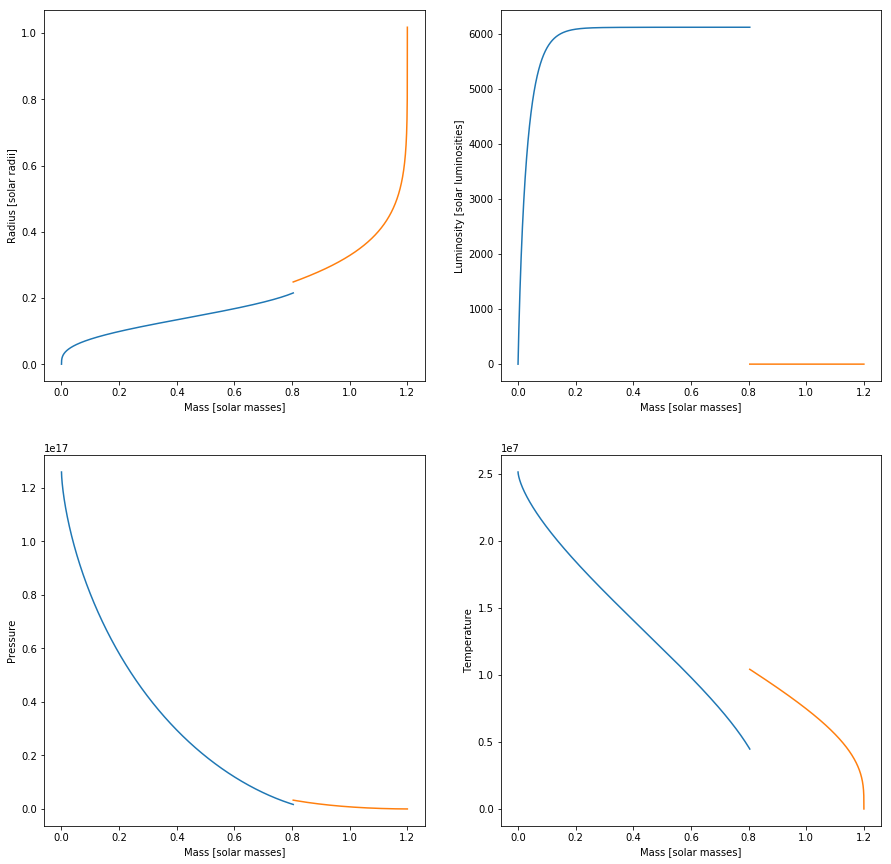

array([-2.30645283e+07,  2.34942850e+30, -1.60996248e+15, -5.94044755e+06])

In [6]:
rlpt = [10**log_rs_i, 10**log_ls_i, 10**log_pc_i, 10**log_tc_i]
model(rlpt=rlpt, do_plot=True)